# Examples of modeling with the py_mrm package

In [1]:
import sys
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import py_mrm as mrm

Default parameters for plots

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['font.serif'] = ['Times New Roman']  # Specify the desired font
plt.rcParams['axes.linewidth'] = 1.5  # Default linewidth for axes
plt.rcParams['lines.linewidth'] = 2.0  # Default linewidth for lines
plt.rcParams['axes.grid'] = True  # Show grid by default

### Counter diffusion + plus reaction in a slab

Reaction: $A+B\rightarrow *$

$\mathrm{div}(-D \, \mathrm{grad} (c_A) ) = -k \, c_A c_B$, $\mathrm{div}(-D \, \mathrm{grad} (c_B)) = -k \, c_A c_B$, 

with boundary conditions: $c_A(0)=1$, $\frac{\partial c_A(L)}{\partial n} = 0$, $\frac{\partial c_B(0)}{\partial n} = 0$, $c_B(L)=1$

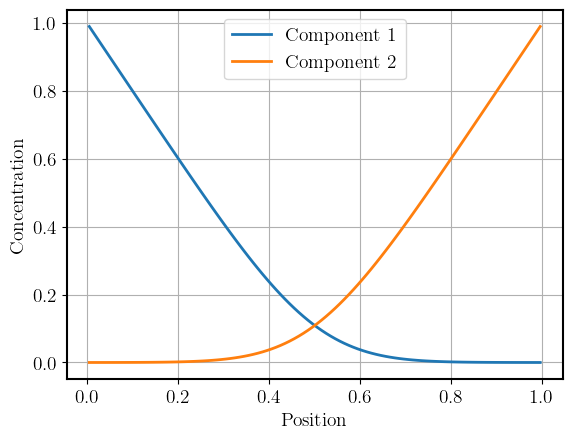

In [3]:
# Define the reaction function
def reaction(c, k):
    f = np.zeros_like(c)
    r = k * c[:, 0] * c[:, 1]
    f[:, 0] = -r
    f[:, 1] = -r
    return f

# Simulation parameters
num_c = 2
num_x = 100
L = 1
c = np.zeros((num_x, num_c))
D = 1
k = 500
# Boundary conditions setup
bc = {'a': [0, 0], 'b': [1, 1], 'd':[ [[1, 0]], [[0, 1]]]}

# Grid setup
x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

# Construct gradient and divergence matrices
Grad, grad_bc = mrm.construct_grad(c.shape, x_f, x_c , bc, axis=0)
Div = mrm.construct_div(c.shape, x_f, nu=0, axis=0)

# Displacement Jacobian
Jac_disp = Div @ (D * Grad)
jac_disp_bc = Div @ (D * grad_bc)

# Iteration loop
for i in range(10):
    Jac_react, f_react = mrm.numjac_local(lambda c: reaction(c, k), c, axis=1)
    g = Jac_disp @ (c.reshape(-1,1)) + jac_disp_bc + f_react.reshape(-1,1)
    lu = sla.splu(Jac_disp + Jac_react)
    c = c - lu.solve(g).reshape(c.shape)

# Plotting the results
plt.plot(x_c, c[:, 0], label='Component 1')
plt.plot(x_c, c[:, 1], label='Component 2')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()


### Counter-current convection + plus reaction

Reaction: $A+B\rightarrow *$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(v_A \, c_A) = -k \, c_A c_B$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(v_B \, c_B) = -k \, c_A c_B$

with boundary conditions: $c_A(0)=1$, $\frac{\partial c_A(L)}{\partial n} = 0$, $\frac{\partial c_B(0)}{\partial n} = 0$, $c_B(L)=1$

Notes: 
- Counter-current flow is implemented by taking $v_B$ negative and setting the proper boundary conditions.
- With $|v_A| > |v_B|$ and same inlet concentrations not all $A$ will react away.
- For high reaction rate coefficient $k$, there is only a thin boundary layer where $B$ is present. If this boundary layer is not resolved the result is incorrect. Uncomment the non-uniform mesh for high $k$.
- This is a numerically tough problem for high reaction rates. Note that TVD deferred correction is currently off, i.e. the upwind scheme is used. TVD seems to decrease robustness.

'progress: 100 out of 100'

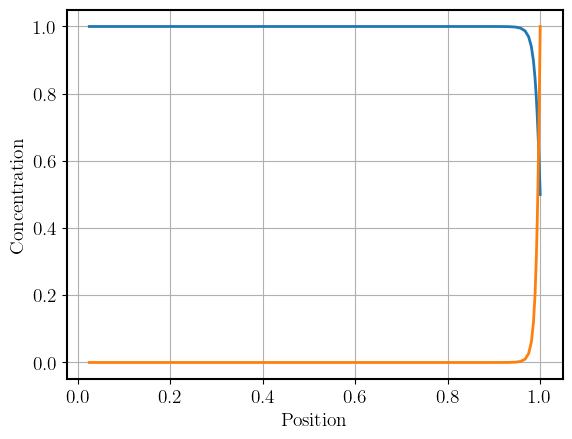

In [4]:
k = 100
dt = 1
num_time_steps = 100
num_inner_iter = 2
v = [[1,-0.5]]
bc = {'a': [ [[0,1]], [[1,0]]], 'b': [[[1,0]], [[0, 1]]], 'd':[ [[1, 0]], [[0, 1]]]}
#x_f = np.linspace(0, L, num_x+1)
x_f = mrm.non_uniform_grid(0, L, num_x+1, 0.05*L, 0.75)
x_c = 0.5*(x_f[:-1] + x_f[1:])
Conv, conv_bc = mrm.construct_convflux_upwind(c.shape, x_f, x_c, bc, v, axis=0)
Div = mrm.construct_div(c.shape, x_f, nu=0, axis=0)
g_const = (Div @ conv_bc)
Jac_const = sp.sparse.eye(c.size, format='csc')/dt + Div @ Conv

c = np.zeros((num_x, num_c))
for i in range(num_time_steps):
    c_old = c
    for j in range(num_inner_iter):
        Jac_react, f_react = mrm.numjac_local(lambda c: reaction(c, k), c, axis = 1)
        Jac = Jac_const - Jac_react
        Jac_lu = sla.splu(Jac)
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, mrm.upwind, axis=0)
#        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, mrm.minmod, axis=0)
        g_conv_deferred = Div @ (v*dc_f).reshape((-1,1))
        g = -c_old.reshape(-1,1)/dt + Jac_const @ c.reshape(-1,1) + g_conv_deferred + g_const -f_react.reshape(-1,1)
        c -= Jac_lu.solve(g).reshape(c.shape)
    clear_output(wait=True)
    display(f'progress: {i+1} out of {num_time_steps}')
    
fig, ax = plt.subplots()
line0, = ax.plot(x_c, c[:, 0])
line1, = ax.plot(x_c, c[:, 1])
ax.set_xlabel('Position')
ax.set_ylabel('Concentration')
fig.canvas.draw()


### Lid-driven cavity

This example is to show that the MRM toolbox is very flexible and that even incompressible Navier-Stokes kan be simulated. The setup is quite complex because of the usage of a staggered mesh. A surprising finding is that in almost all cases the direct sparse solver is faster (or as fast) is ilu + bicgstab. 

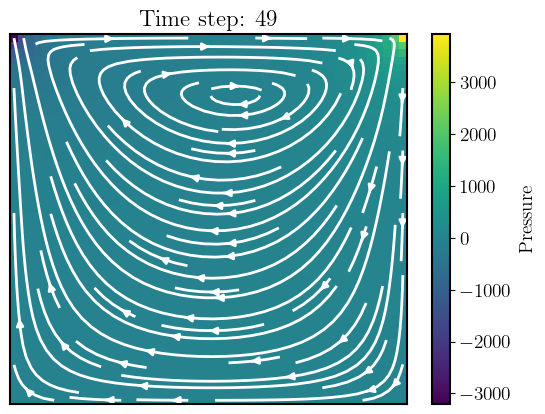

In [5]:
dim = 2 
rho = 1
mu = 1
p_top = 0
v_top = 50
box   = [1.0] * dim
shape_p  = [50] * dim
Co = 0.5
dt = Co*(box[0]/v_top)/shape_p[0]
num_time_steps = 50

x_cntr_c  = [None] * dim # positions cell faces
x_cntr_f  = [None] * dim # cell centered-positions 
x_stagg_c = [None] * dim # staggered positions for velocities
x_stagg_f = [None] * dim # face-positions corresponding to staggered cells
shape_v   = [None] * dim # sizes velocity ndarrays
bc_v      = [None] * dim # velocity bc
v         = [None] * dim
v_old     = [None] * dim
v_cntr    = [None] * dim
Grad_v    = [None] * dim
grad_bc_v = [None] * dim
Div_v     = [None] * dim
Lapl_v    = [None] * dim
lapl_bc_v = [None] * dim
Jac_v     = [None] * dim
Jac_v_pc  = [None] * dim
g_v       = [None] * dim
bc_p      = [None] * dim
Grad_p    = [None] * dim
grad_bc_p = [None] * dim
Div_p     = [None] * dim
p = p_top*np.ones(shape_p)
Lapl_p    = sp.sparse.csc_array((p.size, p.size))
lapl_bc_p = sp.sparse.csc_array((p.size, 1))

for i in range(dim):
    shape_v[i] = shape_p.copy();
    x_cntr_f[i]  = np.linspace(0,box[i],shape_p[i]+1)
    x_cntr_c[i]  = 0.5*(x_cntr_f[i][:-1]+x_cntr_f[i][1:])
    x_stagg_c[i] = x_cntr_f[i][1:-1]
    x_stagg_f[i] = np.concatenate((x_cntr_f[i][0:1], x_cntr_c[i][1:-1], x_cntr_f[i][-1:]), axis=0)
    bc_p[i] = {'a': [1,1], 'b': [0,0], 'd':[0,0]}
    bc_v[i] = [None] * dim
    for j in range(dim):
        shape_v[i][j] = shape_p[j]
        bc_v[i][j] = {'a': [0,0], 'b': [1,1], 'd':[0,0]}
    shape_v[i][i] -= 1
bc_p[-1] = {'a': [1,0], 'b': [0,1], 'd':[0,p_top]}
bc_v[0][-1]['d'][1] = v_top
if (dim ==3):
    bc_v[1][-1]['a'][1] = 1
    bc_v[1][-1]['b'][1] = 0
    bc_v[1][-1]['d'][1] = 0

for i in range(dim):
    Grad_p[i], grad_bc_p[i] = mrm.construct_grad(shape_p, x_cntr_f[i], x_cntr_c[i] , bc_p[i], axis=i)
    Div_p[i] = mrm.construct_div(shape_p, x_cntr_f[i], nu=0, axis=i)
    Lapl_p = Lapl_p + Div_p[i] @ Grad_p[i]
    lapl_bc_p = lapl_bc_p + Div_p[i] @ grad_bc_p[i]
    
    Grad_v[i]    = [None] * dim  
    grad_bc_v[i] = [None] * dim
    Div_v[i]     = [None] * dim 
    v[i] = np.zeros(shape_v[i])
    Lapl_v[i] = sp.sparse.csc_array((v[i].size,v[i].size))
    lapl_bc_v[i] = sp.sparse.csc_array((v[i].size,1))
    for j in range(dim):
        if (i==j):
            Grad_v[i][j], grad_bc_v[i][j] = mrm.construct_grad(shape_v[i], x_stagg_f[j], x_stagg_c[j] , bc_v[i][j], axis=j)
            Div_v[i][j] = mrm.construct_div(shape_v[i], x_stagg_f[j], nu=0, axis=j)
        else:
            Grad_v[i][j], grad_bc_v[i][j] = mrm.construct_grad(shape_v[i], x_cntr_f[j], x_cntr_c[j] , bc_v[i][j], axis=j)
            Div_v[i][j] = mrm.construct_div(shape_v[i], x_cntr_f[j], nu=0, axis=j)
        Lapl_v[i] = Lapl_v[i] + Div_v[i][j] @ Grad_v[i][j]
        lapl_bc_v[i] = lapl_bc_v[i] + Div_v[i][j] @ grad_bc_v[i][j]
    Jac_v[i] = (rho/dt) * sp.sparse.eye(v[i].size, format='csc') - mu * Lapl_v[i]
    Jac_v_ilu = sla.spilu(Jac_v[i])
    Jac_v_pc[i] = sla.LinearOperator(Jac_v_ilu.shape, lambda x: Jac_v_ilu.solve(x))
Lapl_p_ilu = sla.spilu(Lapl_p)
Lapl_p_lu = sla.splu(Lapl_p)
Lapl_p_pc = sla.LinearOperator(Lapl_p_ilu.shape, lambda x: Lapl_p_ilu.solve(x))

X, Y = np.meshgrid(x_cntr_c[0], x_cntr_c[1])

for k in range(num_time_steps):
    div_v = np.zeros((p.size,1))
    for i in range(dim):
        v_old[i] = v[i].copy()
        g_conv = np.zeros((v[i].size,1))
        for j in range(dim):
            if (j == i):
                v_f = mrm.interp_cntr_to_stagg(v[i], x_stagg_f[i], x_stagg_c[i], axis = i)
                vi_f, dvi_f = mrm.interp_cntr_to_stagg_tvd(v[i], x_stagg_f[i], x_stagg_c[i], bc_v[i][j], v_f, mrm.minmod, axis=j)
                conv_flux = rho*vi_f*vi_f            
            else:
                v_f = mrm.interp_stagg_to_cntr(v[j], x_cntr_c[i], x_stagg_c[i], axis = i)
                shape_v_f_bnd = list(v_f.shape)
                shape_v_f_bnd[j] = 1
                v_f = np.concatenate((np.zeros(shape_v_f_bnd), v_f , np.zeros(shape_v_f_bnd)),axis=j)
                vi_f, dvi_f = mrm.interp_cntr_to_stagg_tvd(v[i], x_cntr_f[j], x_cntr_c[j], bc_v[i][j], v_f, mrm.minmod, axis=j)
                conv_flux = rho*v_f*vi_f
            g_conv = g_conv + Div_v[i][j] @ conv_flux.reshape(-1,1)
        shape_p_f = shape_p.copy()
        shape_p_f[i] = shape_p[i]+1
        grad_p = (Grad_p[i] @ p.reshape(-1,1) + grad_bc_p[i]).reshape(shape_p_f)
        idx = [slice(None)] * dim
        idx[i] = slice(1, shape_p_f[i]-1)
        g_grad_p = grad_p[tuple(idx)].reshape(-1,1)                
        g_v[i] = Jac_v[i] @ v[i].reshape(-1,1) - (rho/dt)*v_old[i].reshape(-1,1) + g_conv + g_grad_p - mu*lapl_bc_v[i]
        dv, exit_code = sla.bicgstab(Jac_v[i], g_v[i], M=Jac_v_pc[i])
        #Jac_lu = sla.splu(Jac_v[i])
        #dv = Jac_lu.solve(g_v[i])
        v[i] -= dv.reshape(shape_v[i])
            
        shape_v_bnd = list(v[i].shape)
        shape_v_bnd[i] = 1
        v_incl_wall = np.concatenate((np.zeros(shape_v_bnd), v[i] , np.zeros(shape_v_bnd)),axis=i)
        v_cntr[i] = mrm.interp_stagg_to_cntr(v_incl_wall, x_cntr_f[i], x_cntr_c[i], axis = i)
        div_v += Div_p[i] @ v_incl_wall.reshape(-1,1)

    #dp, exit_code = sla.bicgstab(Lapl_p, (rho/dt)*div_v, M=Lapl_p_pc)
    dp = Lapl_p_lu.solve((rho/dt)*div_v)
    p += dp.reshape(shape_p)
    for i in range(dim):
        shape_p_f = shape_p.copy()
        shape_p_f[i] = shape_p[i]+1
        grad_dp = (Grad_p[i] @ dp.reshape(-1,1)).reshape(shape_p_f)
        idx = [slice(None)] * dim
        idx[i] = slice(1, shape_p_f[i]-1)
        v[i] -= (dt/rho) * grad_dp[tuple(idx)]
        shape_v_bnd = list(v[i].shape)
        shape_v_bnd[i] = 1
        v_incl_wall = np.concatenate((np.zeros(shape_v_bnd), v[i] , np.zeros(shape_v_bnd)),axis=i)
        v_cntr[i] = mrm.interp_stagg_to_cntr(v_incl_wall, x_cntr_f[i], x_cntr_c[i], axis = i)
    clear_output(wait=True)
    plt.figure()
    contour = plt.pcolormesh(x_cntr_f[0], x_cntr_f[1], p.T, shading='flat', cmap='viridis')
    plt.streamplot(X, Y, v_cntr[0].T, v_cntr[1].T, color = 'white')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(contour, label='Pressure')
    plt.title(f"Time step: {k}")
    plt.show()

### Particle model: diffusion + first order reaction
Note that a non-uniform grid us used that is refined at the particle surface. In this way the effectiveness is still accurately computed for larger Thiele moduli.

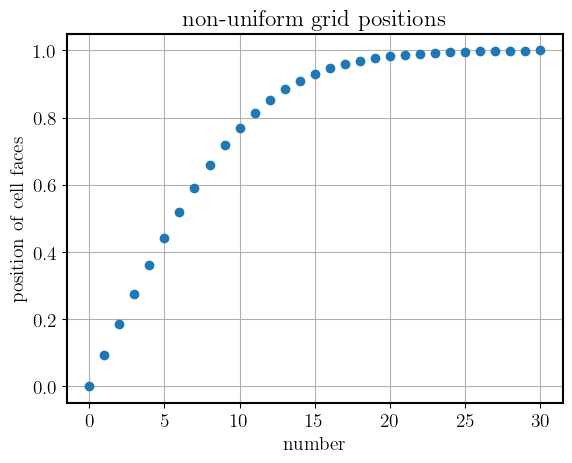

In [6]:
shape_c = (30,)
R = 1
dr_large = 0.1*R
r_f = mrm.non_uniform_grid(0, R, shape_c[0]+1, dr_large, 0.75)
plt.plot(r_f, marker = 'o', linestyle = '')
plt.title("non-uniform grid positions")
plt.xlabel("number")
plt.ylabel("position of cell faces")
plt.show()

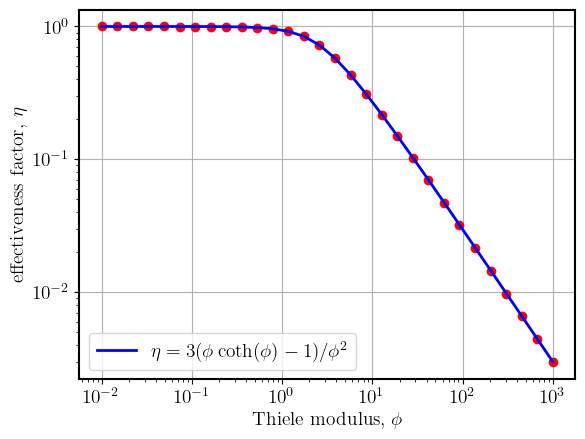

In [7]:
D = 1
phis = np.logspace(-2,3,30)
bc = {'a': [1,0], 'b': [0,1], 'd': [0,1]}
Grad, grad_bc = mrm.construct_grad(shape_c, r_f, bc=bc)
Div = mrm.construct_div(shape_c, r_f, nu=2, axis=0)
Lapl = Div @ Grad
lapl_bc = Div @ grad_bc

for phi in phis:
    k = phi**2*D/R
    Jac = k*sp.sparse.eye(math.prod(shape_c), format='csc') - Lapl
    Jac_lu = sla.splu(Jac)

    c = Jac_lu.solve(lapl_bc.toarray())
    k_app = (Grad[[-1],:] @ c + grad_bc[[-1]].toarray())[[0]]*(3*D/R)
    eta = k_app/k
    c = c.reshape(shape_c)
    plt.loglog(phi, eta, marker = 'o', linestyle = '', color = 'red')
plt.loglog(phis, 3*(phis/np.tanh(phis)-1)/(phis*phis), color = 'blue', label = r'$\eta = 3(\phi \coth(\phi)-1)/\phi^2$')
plt.xlabel(r'Thiele modulus, $\phi$')
plt.ylabel(r'effectiveness factor, $\eta$')
plt.legend()
plt.show()


### TVD schemes

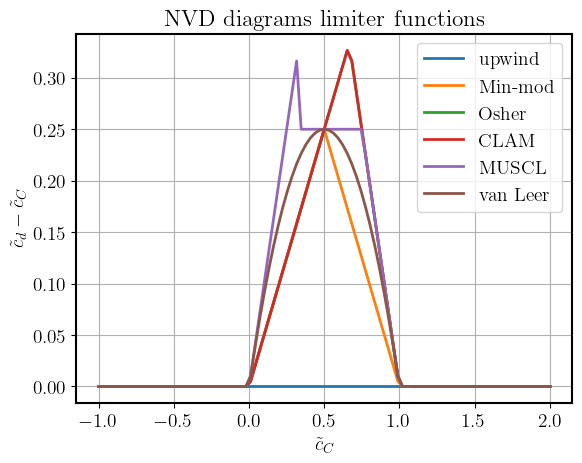

In [8]:
limiters= [
    (mrm.upwind, "upwind"),
    (mrm.minmod, "Min-mod"),
    (mrm.osher, "Osher"),
    (mrm.clam, "CLAM"),
    (mrm.muscl, "MUSCL"),
    (mrm.vanleer, "van Leer")
]

c=np.linspace(-1,2,99)
for func, name in limiters:
    plt.plot(c, func(c, 0.5, 0.75), label=name)
plt.title('NVD diagrams limiter functions')
plt.xlabel(r'$\tilde{c}_C$')
plt.ylabel(r'$\tilde{c}_d - \tilde{c}_C$')
plt.legend()
plt.show()

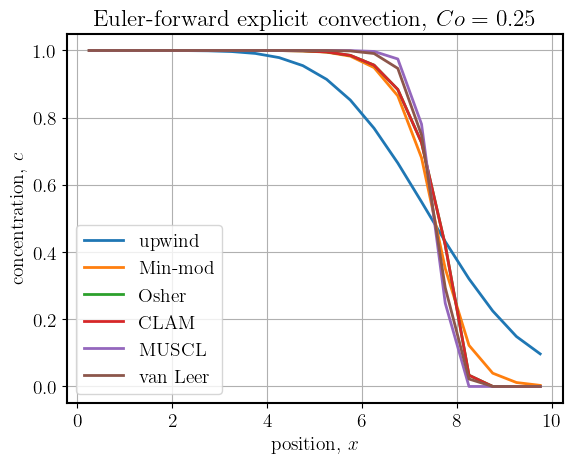

In [9]:
L = 10;
num_x = 20;
v = 1
Co = 0.25;
dt = Co*(L/num_x)/v
num_time_steps = math.floor(0.75*num_x/Co)
x_f = np.linspace(0,L,num_x+1)
x_c = 0.5*(x_f[1:]+x_f[:-1])
bc = {'a': [0,1], 'b': [1,0], 'd':[1,0]}

for func, name in limiters:
    c = np.zeros(num_x)
    for i in range(num_time_steps):
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, tvd_limiter=func, axis=0)
        c += Co*(c_f[:-1]-c_f[1:])
    plt.plot(x_c, c, label=name)
plt.title(fr"Euler-forward explicit convection, $Co=$ {Co}")
plt.xlabel(r'position, $x$')
plt.ylabel(r'concentration, $c$')
plt.legend()
plt.show()

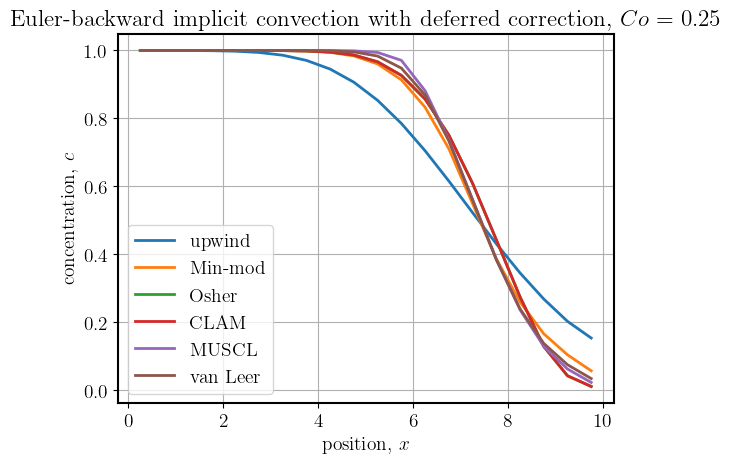

In [10]:
L = 10;
num_x = 20;
v = 1
Co = 0.25;
dt = Co*(L/num_x)/v
num_time_steps = math.floor(0.75*num_x/Co)
x_f = np.linspace(0,L,num_x+1)
x_c = 0.5*(x_f[1:]+x_f[:-1])
bc = {'a': [0,1], 'b': [1,0], 'd':[1,0]}

# Jac = (1/dt*I + Div @ Conv)
# g = (c-c_old)/dt + Div @ (Conv @ c + conv_bc + v*dc_f) 
#   = Jac @ c - c_old/dt + Div @ (conv_bc + v*dc_f)
num_inner_iter = 1
Conv, conv_bc = mrm.construct_convflux_upwind(num_x, x_f, x_c, bc, v, axis=0)
Div = mrm.construct_div(num_x, x_f, nu=0, axis=0)
Jac = (1/dt)*sp.sparse.eye(num_x, format='csc') + Div @ Conv
Jac_lu = sla.splu(Jac)
for func, name in limiters:
    c = np.zeros(num_x)
    for i in range(num_time_steps):
        c_old = c.copy()
        for j in range(num_inner_iter):
            c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, tvd_limiter=func, axis=0)
            g = Jac @ c.reshape(-1,1) - c_old.reshape(-1,1)/dt + Div @ (conv_bc + v*dc_f.reshape(-1,1))
            c -= Jac_lu.solve(g).reshape(c.shape)
    plt.plot(x_c, c, label=name)
plt.title(fr"Euler-backward implicit convection with deferred correction, $Co=$ {Co}")
plt.xlabel(r'position, $x$')
plt.ylabel(r'concentration, $c$')
plt.legend()
plt.show()

### Unsteady convection + reaction 1D

Reaction: $A \rightarrow B\rightarrow C$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(v \, c_A) = -k_1 \, c_A$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(v \, c_B) = k_1 \, c_A - k_2 \, c_B$

$\frac{\partial c_C}{\partial t} + \mathrm{div}(v \, c_C) = k_2 \, c_B$

with boundary conditions: $c_A(0)=0.5, c_B(0)=c_C(0)=0$, $\frac{\partial c_i(L)}{\partial x} = 0$

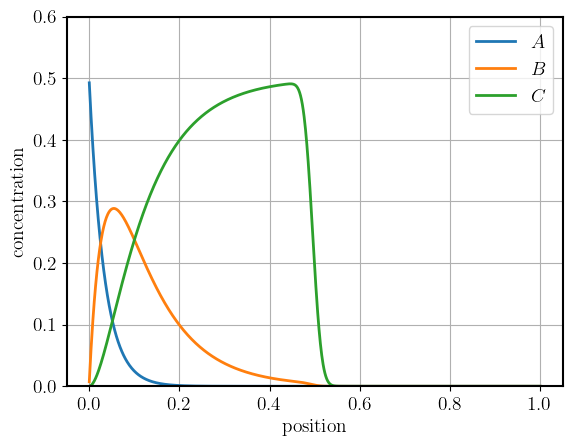

In [11]:
def reaction2(c, k_1, k_2):
    r = np.zeros_like(c)
    r[:,0] = -k_1*c[:,0]
    r[:,1] = k_1*c[:,0] - k_2*c[:,1]
    r[:,2] = k_2*c[:,1]
    return r

L = 1 
v = 0.1
k_1 = 3.0
k_2 = 1.0
t_end = 5

num_x = 1000
num_c = 3
num_time_steps = 1000
num_inner_iter = 1
output_interval = 10
dt = t_end / num_time_steps
c = np.zeros((num_x, num_c))
bc = {'a': [ [[0,0,0]], [[1,1,1]]], 'b': [[[1,1,1]], [[0, 0, 0]]], 'd':[ [[0.5, 0, 0]], [[0, 0, 0]]]}

x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

Conv, conv_bc = mrm.construct_convflux_upwind(c.shape, x_f, x_c, bc, v, axis=0)
Div = mrm.construct_div(c.shape, x_f, nu=0, axis=0)
g_const = (Div @ conv_bc)
Jac_react, f_react = mrm.numjac_local(lambda c: reaction2(c, k_1, k_2), c, axis=1)
Jac = sp.sparse.eye(c.size, format='csc')/dt + Div @ Conv - Jac_react
Jac_lu = sla.splu(Jac)

fig, ax = plt.subplots()
labels = [r'$A$',r'$B$',r'$C$']
lines = [ax.plot(x_c, c[:, j], label=labels[j])[0] for j in range(num_c)]
plt.legend()
plt.xlabel('position')
plt.ylabel('concentration')
plt.ylim(0,0.6)
for i in range(num_time_steps):
    c_old = c.copy().reshape(-1,1)
    for j in range(num_inner_iter):
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, mrm.osher, axis=0)
        g_conv_deferred = Div @ (v*dc_f).reshape((-1,1))
        g = g_const + Jac @ c.reshape(-1,1) - c_old/dt + g_conv_deferred
        c -= Jac_lu.solve(g).reshape(c.shape)
    clear_output(wait=True)
    if (i % output_interval == 0):
        for j in range(num_c):
            lines[j].set_ydata(c[:, j])
        display(fig)

### Unsteady diffusion + reaction 1/2/3D

Reaction: $A \rightarrow B\rightarrow C$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_A)) = -k_1 \, c_A$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_B)) = k_1 \, c_A - k_2 \, c_B$

$\frac{\partial c_C}{\partial t} + \mathrm{div}(-D \, \mathrm{grad}(c_C)) = k_2 \, c_B$

with boundary conditions: $c_A= c_w , c_B=0, c_C(0)=0$

The setup of this problem is more complex than is stricktly necesarry. The puprose is to demonstrate that models can be build in such a way that they can be used in 1, 2 or 3 dimensions.
For 1D and 2D it was found that the direct sparse LU solver works well. For 3D it seems very slow and BiCGStab with an ILU preconditioner is used. Note that the ILU preconditioner takes some time in this case. 

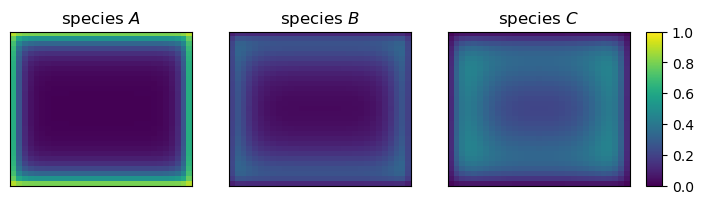

: 

In [2]:
def reaction2(c, k_1, k_2, axis = -1):
    shape_c = c.shape
    shape_t = [math.prod(shape_c[:axis]),shape_c[axis], -1]
    c = c.reshape(shape_t)
    r = np.zeros_like(c)
    r[:,0,:] = -k_1*c[:,0,:]
    r[:,1,:] =  k_1*c[:,0,:] - k_2*c[:,1,:]
    r[:,2,:] =  k_2*c[:,1,:]
    return r.reshape(shape_c)

dim = 2
L = [0.2] * dim
L[0] = 0.1
c_b = 1.0
D = 1e-4
k_1 = 2.0
k_2 = 1.0
t_end = 5

num_c = 3
shape_c = [31] * dim + [num_c]
num_time_steps = 1000
num_inner_iter = 1
output_interval = 100 #num_time_steps
dt = t_end / num_time_steps
c = np.zeros(shape_c)

# All boundaries Dirichlet bc, with c=0. By making sizes=1 broadcasting will be used.
shape_bc = [1] * dim + [num_c]
bc = [{'a': [np.zeros(shape_bc), np.zeros(shape_bc)],
       'b': [np.ones(shape_bc), np.ones(shape_bc)],
       'd': [np.zeros(shape_bc), np.zeros(shape_bc)]} for _ in range(dim)]
# Specify c=1 for component A on all boundaries:
for boundary in bc:
    indcs = (Ellipsis, ) + (0, )
    boundary['d'][0][indcs] = c_b
    boundary['d'][1][indcs] = c_b

x_f = [None]*dim
x_c = [None]*dim
Flux = [None]*dim
flux_bc = [None]*dim
Jac = sp.sparse.eye(math.prod(shape_c), format='csc')/dt
g_const = np.zeros((math.prod(shape_c),1))
for i in range(dim):
    x_f[i] = np.linspace(0,L[i],shape_c[i]+1)
    x_c[i] = 0.5*(x_f[i][:-1]+x_f[i][1:])
    Grad, grad_bc = mrm.construct_grad(shape_c, x_f[i], x_c[i], bc[i], axis=i)
    Flux[i] = -D*Grad
    flux_bc[i] = - D*grad_bc
    Div = mrm.construct_div(shape_c, x_f[i], nu=0, axis=i)
    Jac += Div @ (Flux[i])
    g_const += Div @ (flux_bc[i])
Jac_react, f_react = mrm.numjac_local(lambda c: reaction2(c, k_1, k_2, axis=-1), c, axis=-1)
Jac_react.eliminate_zeros()
Jac -= Jac_react
if (dim==3):
    Jac_ilu = sla.spilu(Jac)
    Jac_pc = sla.LinearOperator(Jac_ilu.shape, lambda x: Jac_ilu.solve(x))
else:
    Jac_lu = sla.splu(Jac)
 
labels = [r'$A$',r'$B$',r'$C$']
if (dim ==1):
    fig, ax = plt.subplots()
    lines = [ax.plot(x_c[0], c[:, j], label=labels[j])[0] for j in range(num_c)]
    plt.ylim(0,1.1)
    ax.set_xlabel('position')
    ax.set_ylabel('concentration')
    plt.legend()
elif ((dim ==2) | (dim==3)):
    fig, ax = plt.subplots(1,num_c, figsize=(8, 2))
    for i in range(num_c):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_title(f'species {labels[i]}')
    contour = [None] * num_c  
    if (dim==2):
        for i in range(num_c):    
            contour[i] = ax[i].pcolormesh(x_f[0], x_f[1], c[:,:, i], shading='flat', cmap='viridis', vmin=0, vmax=c_b)
    else:
        indx_z = math.floor(shape_c[dim-1]/2)
        for i in range(num_c):
            contour[i] = ax[i].pcolormesh(x_f[0], x_f[1], c[:,:,indx_z, i], shading='flat', cmap='viridis', vmin=0, vmax=c_b)    
    cbar_ax = fig.add_axes([0.92, ax[0].get_position().y0, 0.02, ax[0].get_position().y1-ax[0].get_position().y0])  # Adjust the parameters as needed [left, bottom, width, height]
    plt.colorbar(contour[0], cax=cbar_ax)
plt.show()

for i in range(num_time_steps):
    c_old = c.copy().reshape(-1,1)
    for j in range(num_inner_iter):
        g = g_const + Jac @ c.reshape(-1,1) - c_old/dt
        if (dim==3):
            dc, exit_code = sla.bicgstab(Jac, g, M=Jac_pc)
            c -= dc.reshape(c.shape)
        else:
            c -= Jac_lu.solve(g).reshape(c.shape)
#        clear_output(wait=True)
#        display(f'solving: progress {100*i/num_time_steps}%')
    if ((i+1) % output_interval == 0):
        clear_output(wait=True)
        if (dim==1):
            for j in range(num_c):
                lines[j].set_ydata(c[:, j])  
        elif (dim==2):
            for i in range(num_c):
                contour[i].set_array(c[:,:,i].ravel())
        elif (dim==3):
            for i in range(num_c):
                contour[i].set_array(c[:,:,indx_z,i].ravel())
        display(fig)

### Darcy flow in a 2D domain with varying permeability

$\mathrm{div}(-\frac{k}{\mu} \mathrm{grad}(p)) =0$

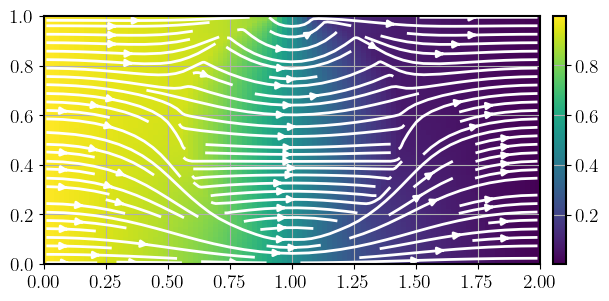

In [13]:
# For ease of 2D plotting, and in accordance with ij indexing 
# of matrices where j is the x-direction, we here associate 
# x with dimension 1 and y with dimension 0

dim = 2
L = 1.0
cntr = [0.55*L, L]
R = 0.45*L
box = [L,2*L]
k_ext = 1
k_int = 0.05
mu = 1
shape_p = [100,100]

def permeability_field(x):
    x0 = x[0].reshape(-1,1)
    x1 = x[1].reshape(1,-1)
    k = k_ext + (k_int-k_ext)*(((x0-cntr[0])*(x0-cntr[0])+(x1-cntr[1])*(x1-cntr[1]))<R*R)
    return k

x_f = [None] * dim
x_c = [None] * dim
for i in range(dim):
    x_f[i] = np.linspace(0,box[i], shape_p[i]+1)
    x_c[i] = 0.5*(x_f[i][1:]+x_f[i][:-1])

bc = [None]*dim
bc[0] = {'a': [1,1], 'b': [0,0], 'd':[0,0]}
bc[1] = {'a': [0,0], 'b': [1,1], 'd':[1,0]}

# permeabilities at face positions
k_f = [None]*dim
k_f[0] = permeability_field((x_f[0], x_c[1]))
k_f[1] = permeability_field((x_c[0], x_f[1]))

Flux = [None]*dim
flux_bc = [None]*dim
Lapl = sp.sparse.csc_array((math.prod(shape_p),math.prod(shape_p)))
lapl_bc = np.zeros((math.prod(shape_p),1))
for i in range(dim):
    Grad, grad_bc = mrm.construct_grad(shape_p, x_f[i], x_c[i], bc[i], axis=i)
    K = mrm.construct_coefficient_matrix(k_f[i]/mu)
    Flux[i] = -K @ Grad
    flux_bc[i] = - K @ grad_bc
    Div = mrm.construct_div(shape_p, x_f[i], nu=0, axis=i)
    Lapl += Div @ Flux[i]
    lapl_bc += Div @ flux_bc[i]
Lapl_lu = sla.splu(Lapl)
p = -Lapl_lu.solve(lapl_bc).reshape(shape_p)

flux_c = [None]*dim
for i in range(dim):
    shape_f = shape_p.copy()
    shape_f[i] +=1
    flux = (Flux[i]@p.reshape(-1,1)+flux_bc[i]).reshape(shape_f)
    flux_c[i] = mrm.interp_stagg_to_cntr(flux, x_f[i], x_c[i], axis=i)

fig, ax = plt.subplots()
contour = ax.pcolormesh(x_f[1], x_f[0], p, shading='flat', cmap='viridis')
X,Y = np.meshgrid(x_c[1], x_c[0],indexing='xy')
ax.streamplot(X, Y, flux_c[1], flux_c[0], color = 'white')
ax.set_xlim(x_f[1][0], x_f[1][-1])
ax.set_ylim(x_f[0][0], x_f[0][-1])
ax.set_aspect('equal')
cbar_ax = fig.add_axes([0.92, ax.get_position().y0, 0.02, ax.get_position().y1-ax.get_position().y0])  # Adjust the parameters as needed [left, bottom, width, height]
plt.colorbar(contour, cax=cbar_ax)
plt.show()